In [3]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [8]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
recent_data = session.query(Measurement).order_by(Measurement.id.desc()).first()
recent_data.date

'2017-08-23'

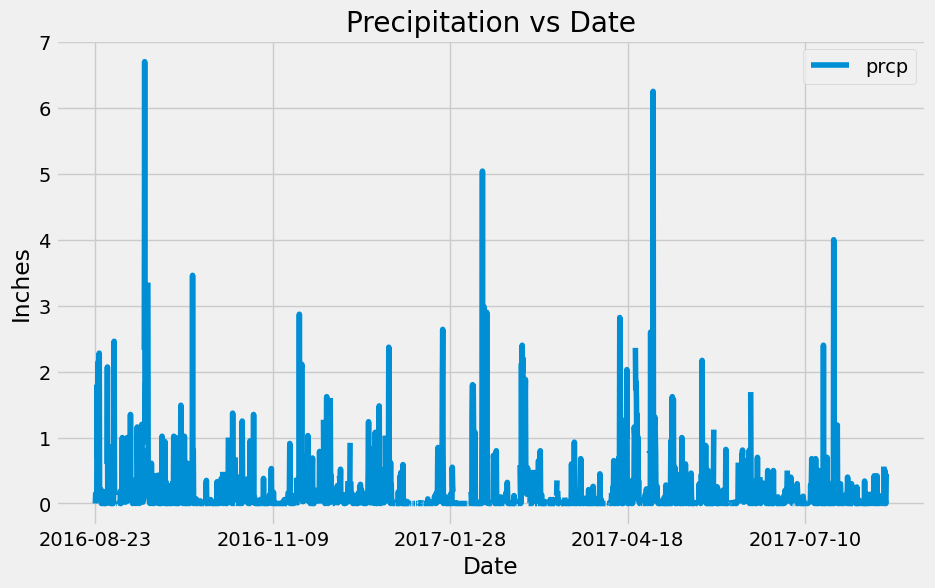

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
recent_data = session.query(Measurement).order_by(Measurement.id.desc()).first()
one_year = session.query(Measurement.date).filter(Measurement.date >= '2016-08-23').order_by(Measurement.date).all()

# Perform a query to retrieve the data and precipitation scores
data_prcp = session.query(Measurement.station,Measurement.date,Measurement.prcp,Measurement.tobs).filter(Measurement.date >= '2016-08-23').order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
data_prcp_df = pd.DataFrame(data_prcp,columns=['station','date','prcp','tobs'])

# Sort the dataframe by date
df_sorted = data_prcp_df.sort_values(by='date')

# Use Pandas Plotting with Matplotlib to plot the data
df_sorted.plot(x='date', y='prcp', kind='line', figsize=(10,6))
plt.title('Precipitation vs Date')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.grid(True)
plt.show()


In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = df_sorted['prcp'].describe()
print(summary_statistics)

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number of stations in the dataset
total_count = session.query(Station).distinct().count()
total_count

9

In [16]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active= session.query(Measurement.station, func.count(Measurement.station).label('station')) \
                              .group_by(Measurement.station) \
                              .order_by(func.count(Measurement.station).desc()) \
                              .all()
most_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = 'USC00519281'
temperature_stats = session.query(func.min(Measurement.tobs).label('lowest_temperature'),
                                  func.max(Measurement.tobs).label('highest_temperature'),
                                  func.avg(Measurement.tobs).label('average_temperature')) \
                           .filter(Measurement.station == most_active_station_id) \
                           .first()
temperature_stats

(54.0, 85.0, 71.66378066378067)

In [18]:
#Query the previous 12 months of TOBS data for that station.
latest_date = session.query(func.max(Measurement.date)).filter(Measurement.station == most_active_station_id).scalar()
one_year_ago = '2016-08-18'
print(latest_date)

2017-08-18


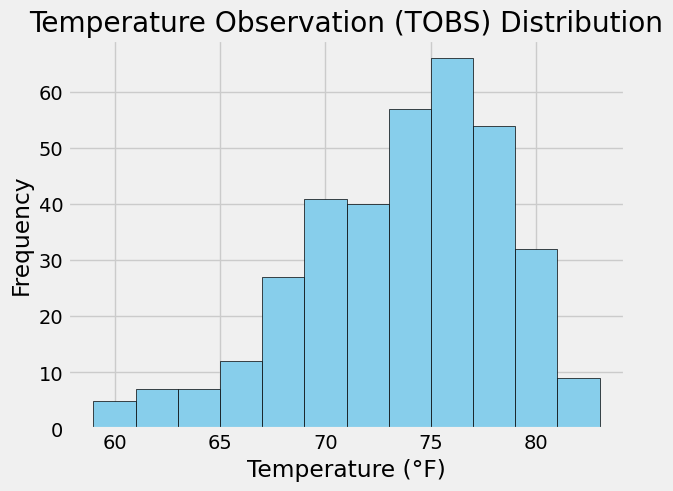

In [72]:
#Design a query to get the previous 12 months of temperature observation (TOBS) data. 
#To do so, complete the following steps:

#Filter by the station that has the greatest number of observations.
most_active_station_id = 'USC00519281'

#Query the previous 12 months of TOBS data for that station.
latest_date = session.query(func.max(Measurement.date)).filter(Measurement.station == most_active_station_id).scalar()
one_year_ago = '2016-08-18'

#Plot the results as a histogram with bins=12, as the following image shows:
temperature_observation_data = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == most_active_station_id).filter(Measurement.date >= one_year_ago).filter(Measurement.date <= latest_date).all()
tobs_df = pd.DataFrame(temperature_observation_data, columns=['date', 'tobs'])


#Correctly plot a histogram with bins=12 for the last year of data using tobs as the column to count.
plt.hist(tobs_df['tobs'], bins=12, color='skyblue', edgecolor='black')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title('Temperature Observation (TOBS) Distribution')
plt.show()

# Close Session

In [73]:
# Close Session
session.close()